In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import anderson
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Load the dataset
df = pd.read_csv('customer_data.csv')
df.head()

,id,age,gender,income,education,region,loyalty_status,purchase_frequency,purchase_amount,product_category,promotion_usage,satisfaction_score
0,1,27,Male,40682,Bachelor,East,Gold,frequent,18249,Books,0,6
1,2,29,Male,15317,Masters,West,Regular,rare,4557,Clothing,1,6
2,3,37,Male,38849,Bachelor,West,Silver,rare,11822,Clothing,0,6
3,4,30,Male,11568,HighSchool,South,Regular,frequent,4098,Food,0,7
4,5,31,Female,46952,College,North,Regular,occasional,19685,Clothing,1,5


In [3]:
rename_columns_dict = {
    'age': 'Age',
    'gender': 'Gender',
    'income': 'Income',
    'education': 'Education',
    'region': 'Region',
    'loyalty_status': 'Loyalty_Status',
    'purchase_frequency': 'Purchase_Frequency',
    'purchase_amount': 'Purchase_Amount',
    'product_category': 'Product_Category',
    'promotion_usage': 'Promotion_Usage',
    'satisfaction_score': 'Satisfaction_Score'
}

df = df.rename(columns=rename_columns_dict)

# Check for Null Values

In [42]:
# Convert Categorical columns to the Category datatype
categorical_columns = ['Gender', 'Education', 'Region', 'Loyalty_Status', 'Purchase_Frequency',
                       'Product_Category', 'Promotion_Usage']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Convert ID to String since it won't be used in the analysis
df['id'] = df['id'].astype(str)

In [45]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  100000 non-null  object  
 1   Age                 100000 non-null  int64   
 2   Gender              100000 non-null  category
 3   Income              100000 non-null  int64   
 4   Education           100000 non-null  category
 5   Region              100000 non-null  category
 6   Loyalty_Status      100000 non-null  category
 7   Purchase_Frequency  100000 non-null  category
 8   Purchase_Amount     100000 non-null  int64   
 9   Product_Category    100000 non-null  category
 10  Promotion_Usage     100000 non-null  category
 11  Satisfaction_Score  100000 non-null  int64   
dtypes: category(7), int64(4), object(1)
memory usage: 4.5+ MB


In [5]:
# Loop through each column and print value counts
for column in df.columns:
    print(df[column].value_counts(dropna=False))
    print("\n")

1         1
66651     1
66673     1
66672     1
66671     1
         ..
33332     1
33331     1
33330     1
33329     1
100000    1
Name: id, Length: 100000, dtype: int64


30    8867
31    8645
29    8636
28    8266
32    8034
33    7214
27    7022
34    5894
26    5882
35    4873
25    4856
36    3583
24    3576
37    2697
23    2636
38    1791
22    1790
39    1200
21    1187
20     743
40     682
41     481
19     457
42     242
18     233
17     143
43     125
16      66
44      58
15      39
45      35
47      13
14      13
46      11
13       4
12       3
48       2
49       1
Name: Age, dtype: int64


Female    50074
Male      49926
Name: Gender, dtype: int64


39596    12
28944    10
12803    10
36828    10
21832     9
         ..
47076     1
44614     1
14934     1
45093     1
35207     1
Name: Income, Length: 40003, dtype: int64


College       39874
Bachelor      30279
HighSchool    20031
Masters        9816
Name: Education, dtype: int64


East     30074
West     29935
Sout

# Check for Duplicates

In [6]:
# Check for complete duplicates
if df.duplicated().any():
    print('Has complete duplicates')
else:
    print('No complete duplicates')

No complete duplicates


# Check for Outliers

In [49]:
df = df.drop(columns='id')

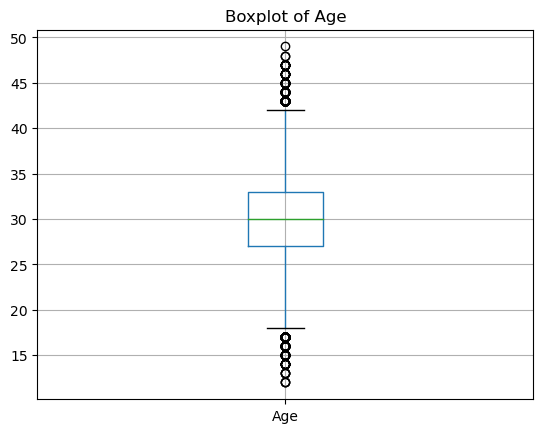

Age has 513 outliers


Value counts for Gender
Female    50074
Male      49926
Name: Gender, dtype: int64




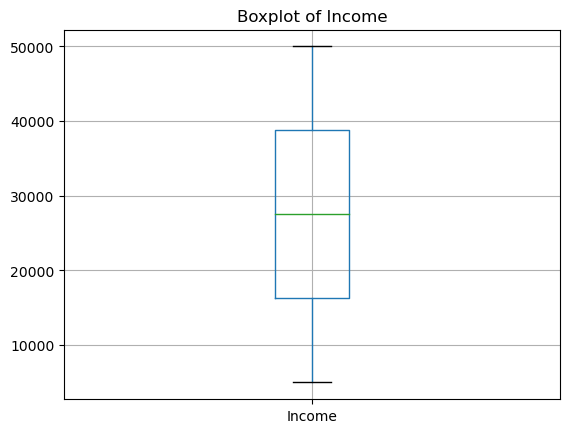

Income has 0 outliers


Value counts for Education
College       39874
Bachelor      30279
HighSchool    20031
Masters        9816
Name: Education, dtype: int64



Value counts for Region
East     30074
West     29935
South    20073
North    19918
Name: Region, dtype: int64



Value counts for Loyalty_Status
Regular    60138
Silver     29964
Gold        9898
Name: Loyalty_Status, dtype: int64



Value counts for Purchase_Frequency
rare          50019
occasional    29886
frequent      20095
Name: Purchase_Frequency, dtype: int64




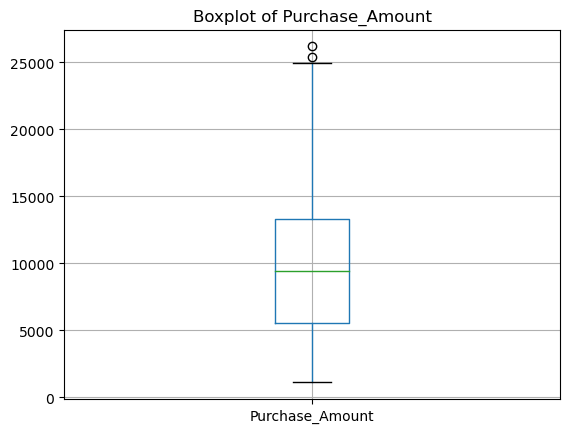

Purchase_Amount has 2 outliers


Value counts for Product_Category
Electronics    30027
Clothing       19989
Books          14925
Food           14822
Health         10123
Home            5079
Beauty          5035
Name: Product_Category, dtype: int64



Value counts for Promotion_Usage
0    69920
1    30080
Name: Promotion_Usage, dtype: int64




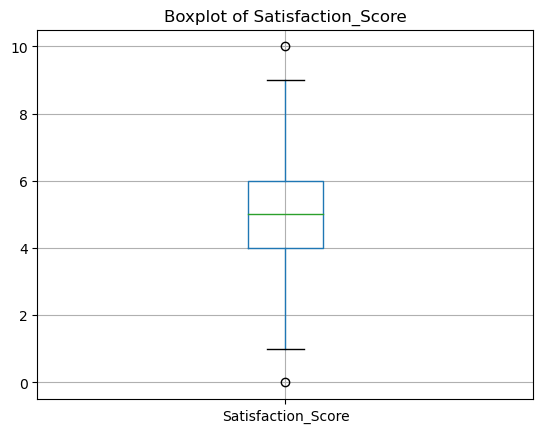

Satisfaction_Score has 2 outliers



In [50]:
# Create boxplot and if outliers exist, calculate using IQR method
for col in df.columns:
    if df[col].dtype != 'category':
        # Create boxplot
        df.boxplot(column=col)
        plt.title(f'Boxplot of {col}')
        plt.show()
        
        # Calculate IQR lower and upper bounds to determine outliers
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count and display outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers = outliers.shape[0]
        print(f"{col} has {num_outliers} outliers")
        print()
        
        
    else:
        # For categorical variables, determine if any category makes up a small percentage
        print()
        print(f'Value counts for {col}')
        print(df[col].value_counts())
        print('\n')

# Summary Statistics

In [54]:
# Produce summary statistics for each variable
for col in df.columns:
    print(f'Summary statistics for {col}')
    print(df[col].describe())
    print()

Summary statistics for Age
count    100000.000000
mean         30.003260
std           4.480535
min          12.000000
25%          27.000000
50%          30.000000
75%          33.000000
max          49.000000
Name: Age, dtype: float64

Summary statistics for Gender
count     100000
unique         2
top       Female
freq       50074
Name: Gender, dtype: object

Summary statistics for Income
count    100000.000000
mean      27516.269880
std       12996.782587
min        5000.000000
25%       16271.750000
50%       27584.500000
75%       38747.250000
max       50000.000000
Name: Income, dtype: float64

Summary statistics for Education
count      100000
unique          4
top       College
freq        39874
Name: Education, dtype: object

Summary statistics for Region
count     100000
unique         4
top         East
freq       30074
Name: Region, dtype: object

Summary statistics for Loyalty_Status
count      100000
unique          3
top       Regular
freq        60138
Name: Loyalty_Sta

# Univariate Visualizations

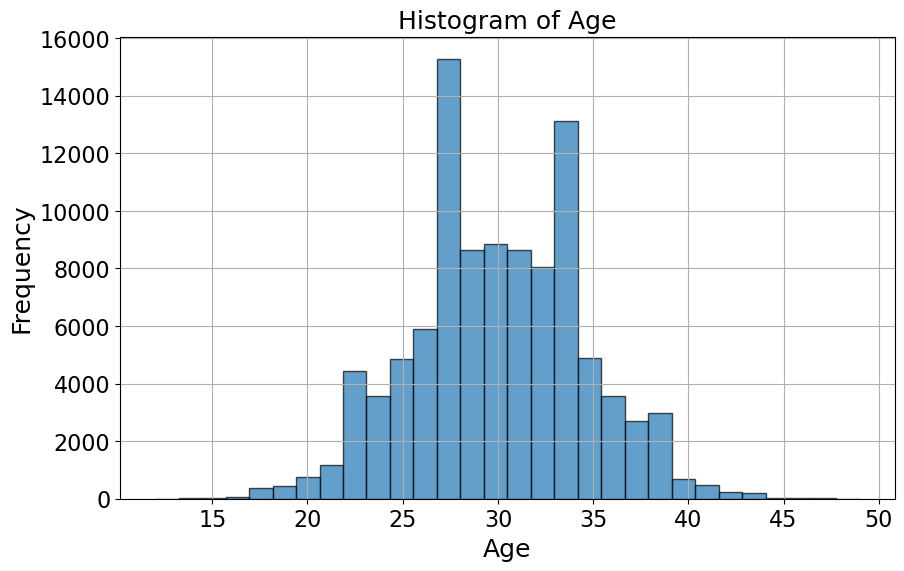

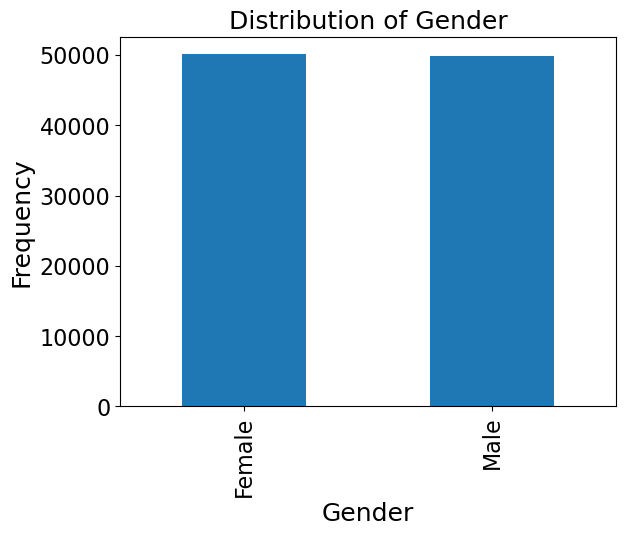

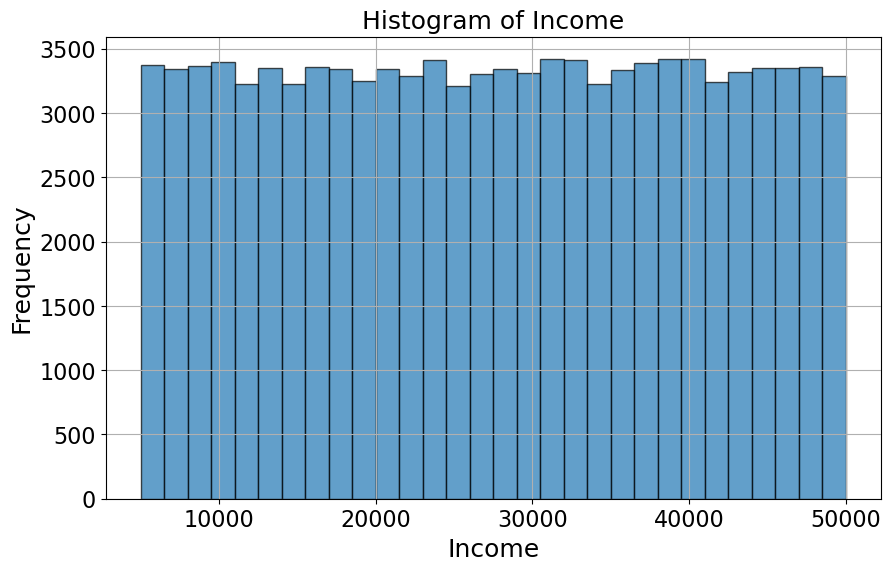

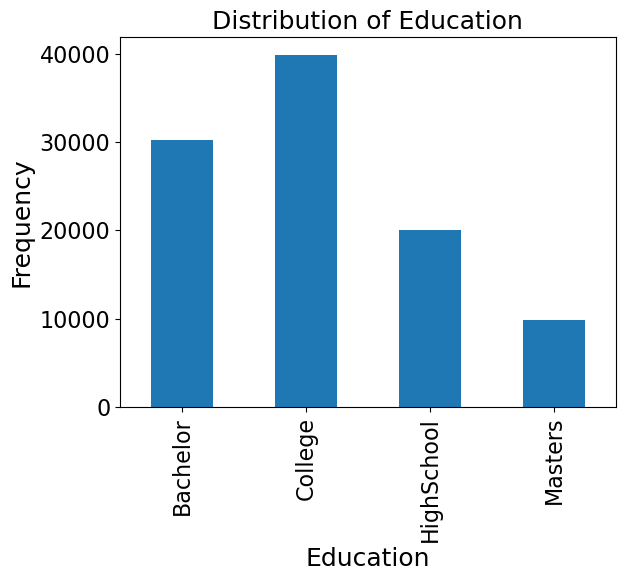

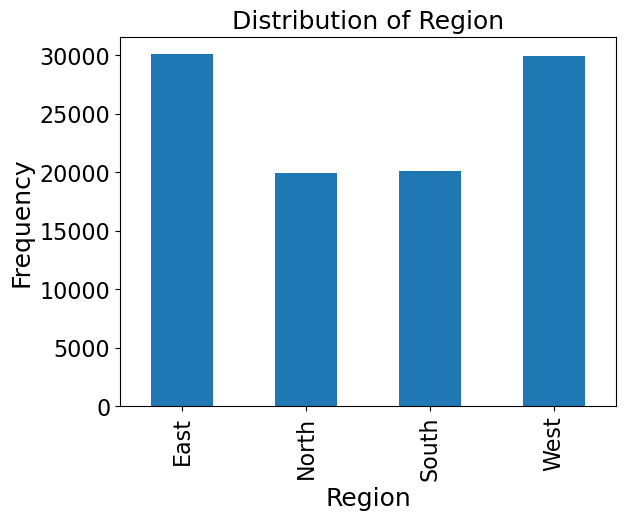

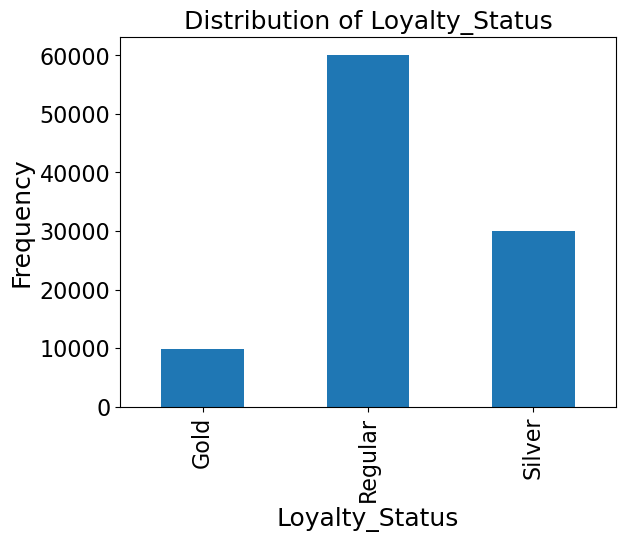

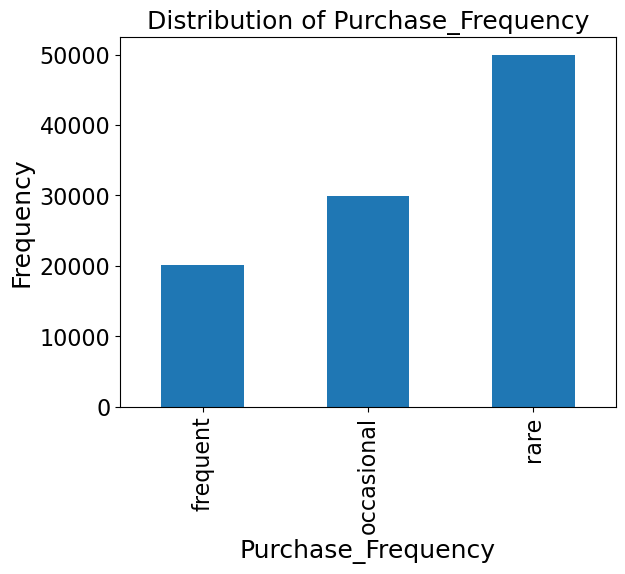

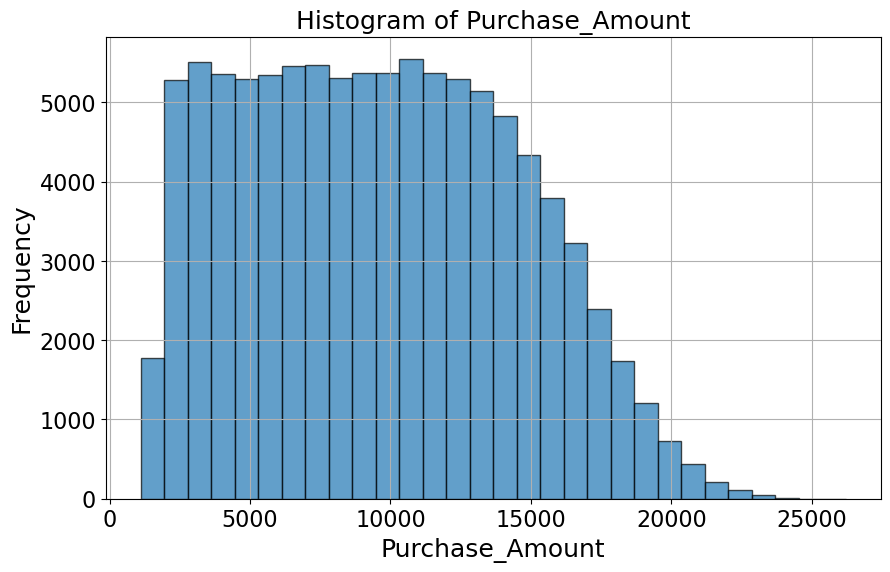

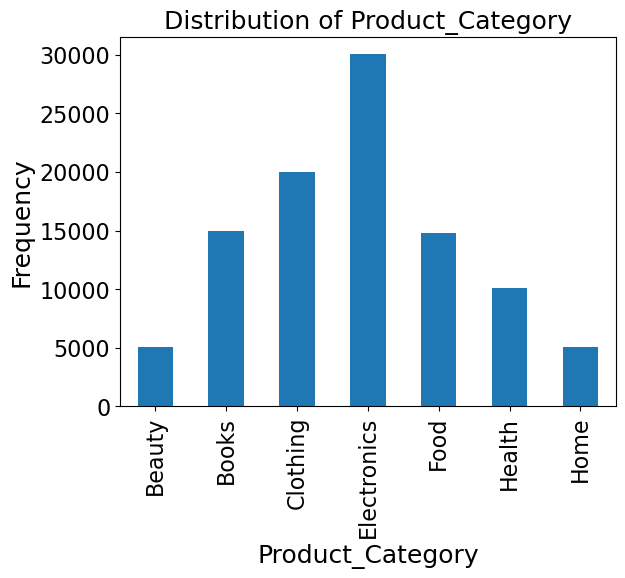

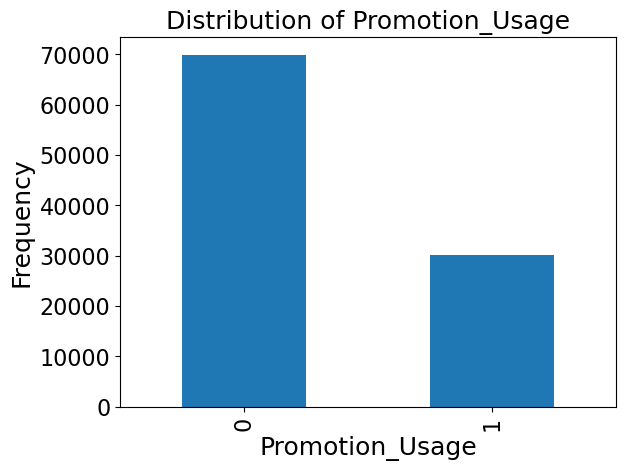

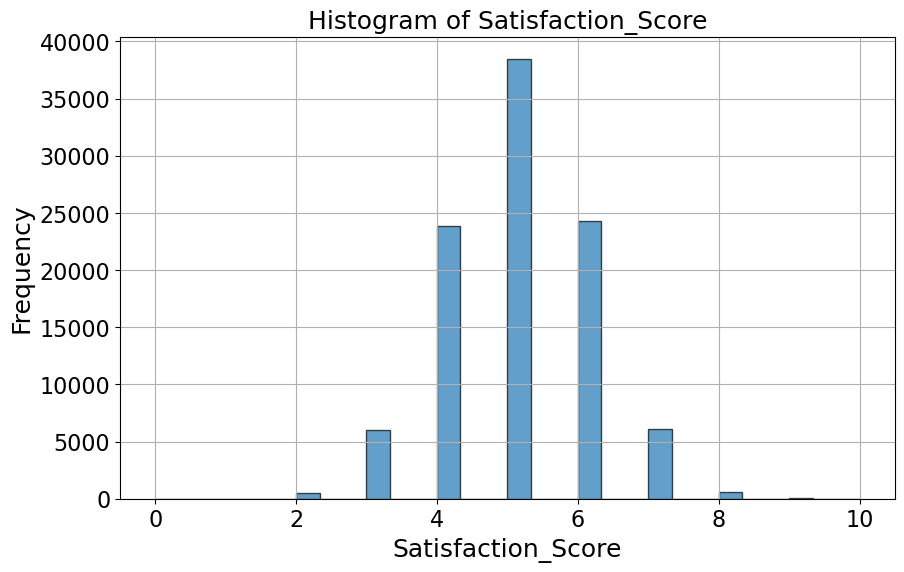

In [52]:
# Create univariate visualizations for each variable
for col in df.columns:
    if (df[col].dtype != 'category'):
        plt.figure(figsize=(10, 6))
        plt.hist(df[col], bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'Histogram of {col}', fontsize=18)
        plt.xlabel(col, fontsize=18)
        plt.ylabel('Frequency', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.grid(True)
        plt.show()
    else:
        value_counts = df[col].value_counts().sort_index()
        value_counts.plot(kind='bar')
        plt.title(f'Distribution of {col}', fontsize=18)
        plt.xlabel(col, fontsize=18)
        plt.ylabel('Frequency', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.show()

# Bivariate Visualizations

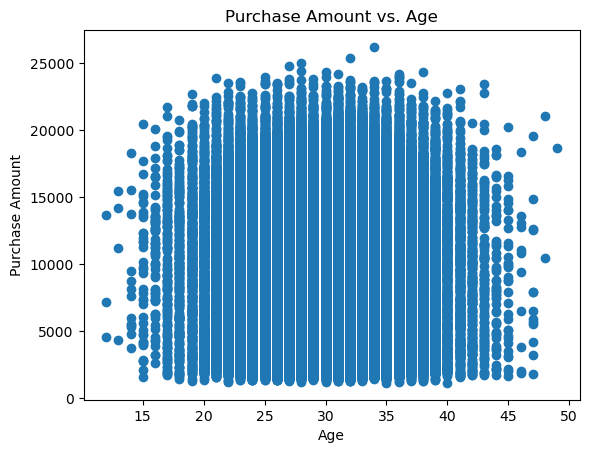

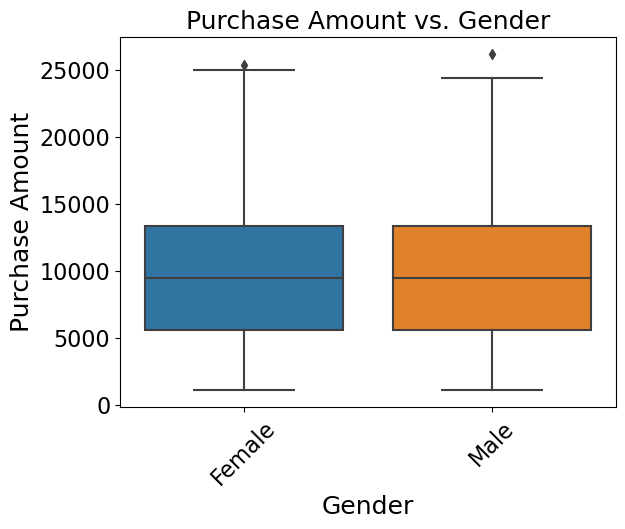

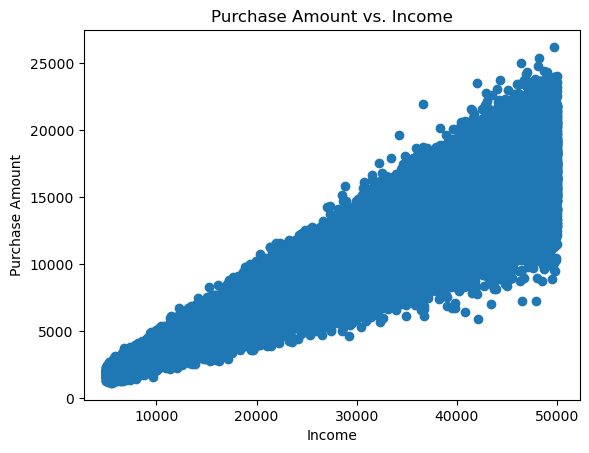

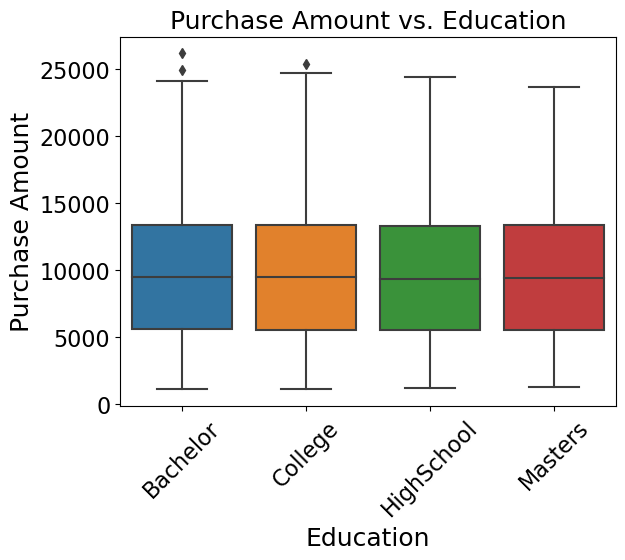

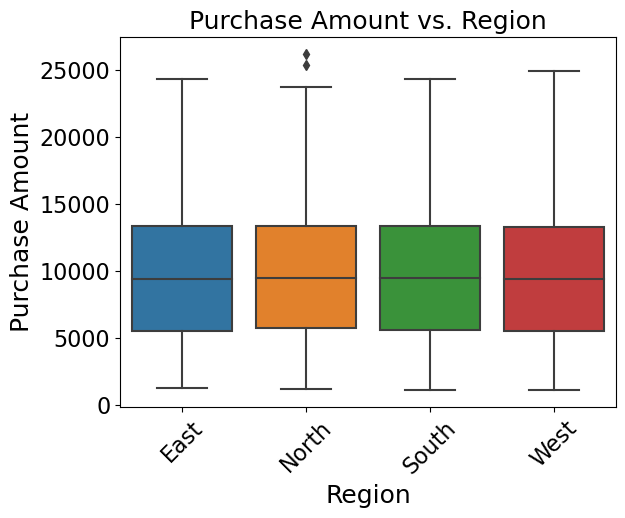

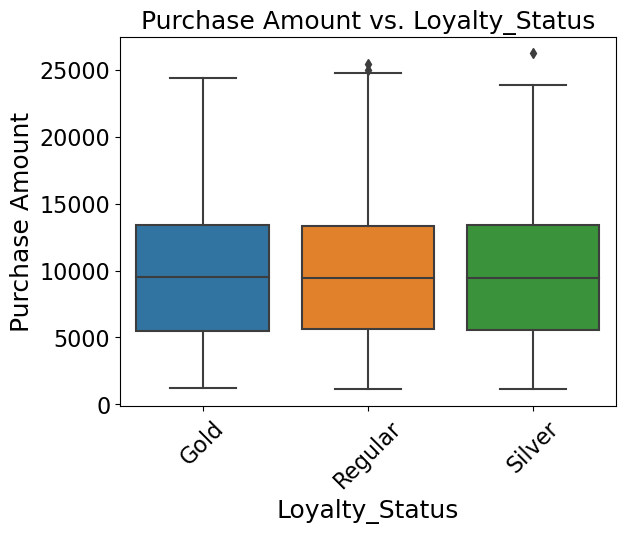

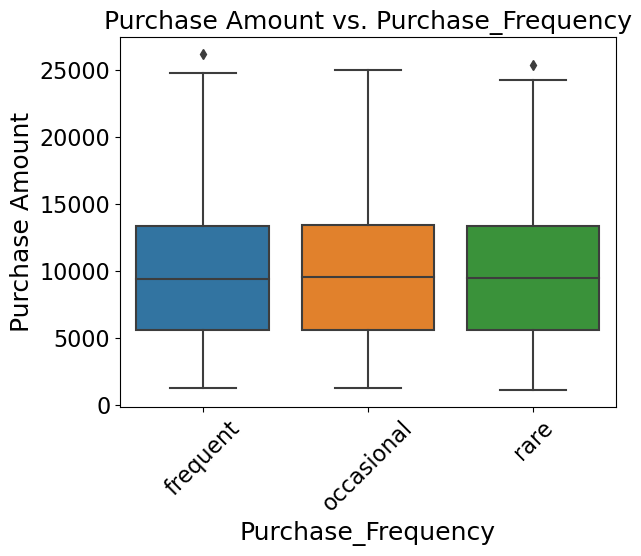

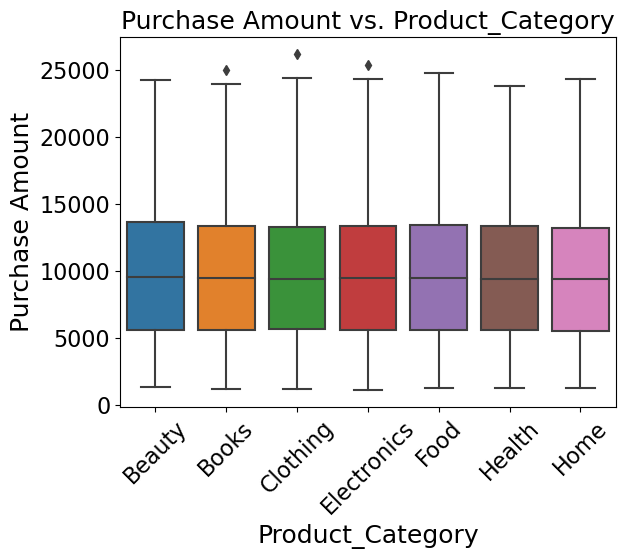

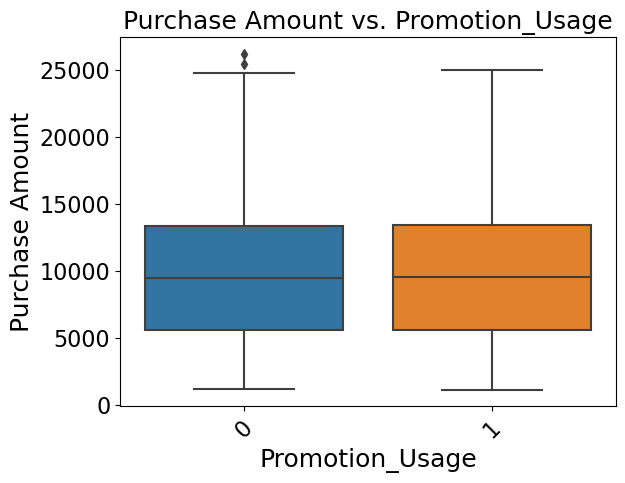

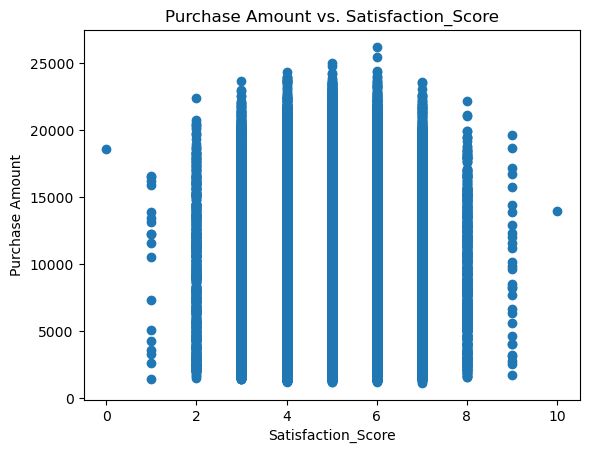

In [53]:
# Create bivariate visualizations for each dependent/independent variable combination
for col in df.columns:
    if col != 'Purchase_Amount':
        # Scatterplot if continuous vs. continuous
        if df[col].dtype != 'category':
            plt.scatter(df[col], df['Purchase_Amount'])
            plt.title(f'Purchase Amount vs. {col}')
            plt.xlabel(col)
            plt.ylabel('Purchase Amount')
            plt.show()
        # Boxplot if continuous vs. categorical
        else:
            sns.boxplot(x=col, y='Purchase_Amount', data=df)
            plt.title(f'Purchase Amount vs. {col}', fontsize=18)
            plt.xlabel(col, fontsize=18)
            plt.ylabel('Purchase Amount', fontsize=18)
            plt.tick_params(axis='x', which='major', labelsize=14, rotation=45)
            plt.tick_params(axis='both', which='major', labelsize=16)
            plt.show()

# Determine Parametric vs. Non-Parametric Method

In [55]:
# Calculate Pearson correlation coefficients
continuous_variables = ['Age', 'Income', 'Satisfaction_Score']

correlations = df[continuous_variables].corrwith(df['Purchase_Amount'])
print(correlations)

Age                  -0.002089
Income                0.948441
Satisfaction_Score    0.003424
dtype: float64


In [56]:
# ANOVA for Categorical vs Continuous
categorical_variables = ['Gender', 'Education', 'Region', 'Loyalty_Status', 'Purchase_Frequency', 
                    'Product_Category', 'Promotion_Usage']

for var in categorical_variables:
    model = ols(f'Purchase_Amount ~ C({var})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {var}:")
    print(anova_table)
    print("\n")


ANOVA results for Gender:
                 sum_sq       df        F    PR(>F)
C(Gender)  1.496226e+04      1.0  0.00065  0.979667
Residual   2.303343e+12  99998.0      NaN       NaN


ANOVA results for Education:
                    sum_sq       df         F    PR(>F)
C(Education)  7.120691e+07      3.0  1.030477  0.377747
Residual      2.303272e+12  99996.0       NaN       NaN


ANOVA results for Region:
                 sum_sq       df         F    PR(>F)
C(Region)  5.212572e+07      3.0  0.754336  0.519648
Residual   2.303291e+12  99996.0       NaN       NaN


ANOVA results for Loyalty_Status:
                         sum_sq       df         F    PR(>F)
C(Loyalty_Status)  4.452398e+06      2.0  0.096648  0.907876
Residual           2.303338e+12  99997.0       NaN       NaN


ANOVA results for Purchase_Frequency:
                             sum_sq       df         F    PR(>F)
C(Purchase_Frequency)  3.191481e+07      2.0  0.692782  0.500185
Residual               2.303311e+12  99997.

In [57]:
# Define predictor and target variable
X = df[['Income']]
y = df['Purchase_Amount']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
linear_model = sm.OLS(y, X).fit()

print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Purchase_Amount   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 8.954e+05
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:49:55   Log-Likelihood:            -8.7462e+05
No. Observations:              100000   AIC:                         1.749e+06
Df Residuals:                   99998   BIC:                         1.749e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2924     11.263     -0.204      0.8

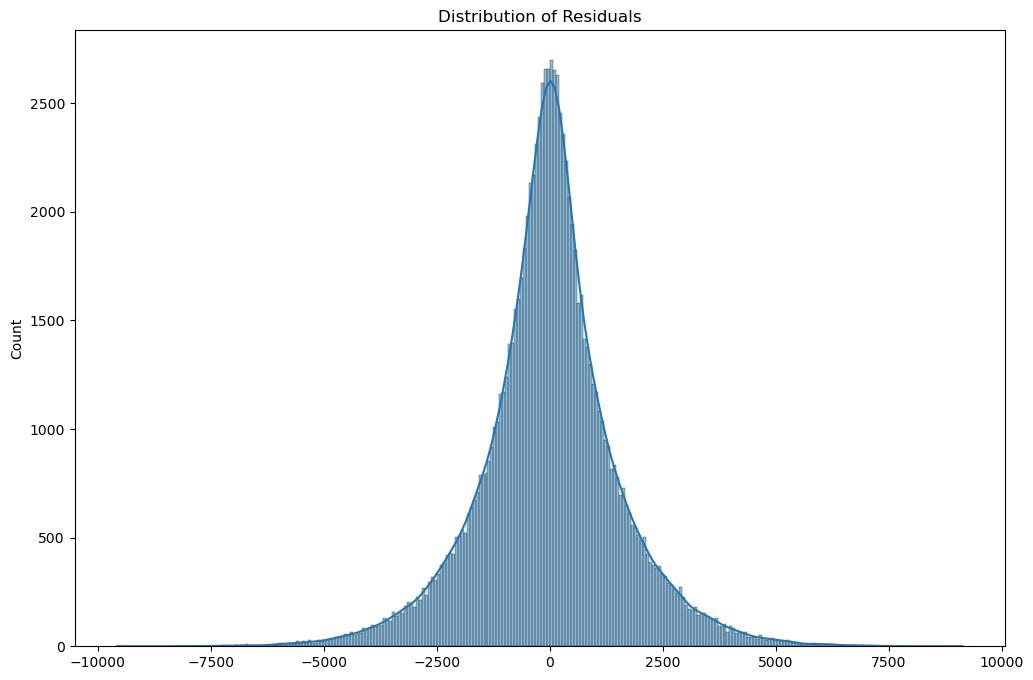

In [58]:
# Obtain residuals
residuals = linear_model.resid

# Plot residuals
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

In [16]:
# Anderson-Darling Test on residuals
result_ad = anderson(residuals)
print('Anderson-Darling Test on Residuals:')
print(f'Statistic: {result_ad.statistic}')
for i in range(len(result_ad.critical_values)):
    sig_level, critical_value = result_ad.significance_level[i], result_ad.critical_values[i]
    print(f'Critical value for {sig_level}% significance level: {critical_value}')
print(f'The residuals {"are not" if result_ad.statistic > result_ad.critical_values[2] else "are"} normally distributed (reject the null hypothesis).')

Anderson-Darling Test on Residuals:
Statistic: 772.0250552234793
Critical value for 15.0% significance level: 0.576
Critical value for 10.0% significance level: 0.656
Critical value for 5.0% significance level: 0.787
Critical value for 2.5% significance level: 0.918
Critical value for 1.0% significance level: 1.092
The residuals are not normally distributed (reject the null hypothesis).


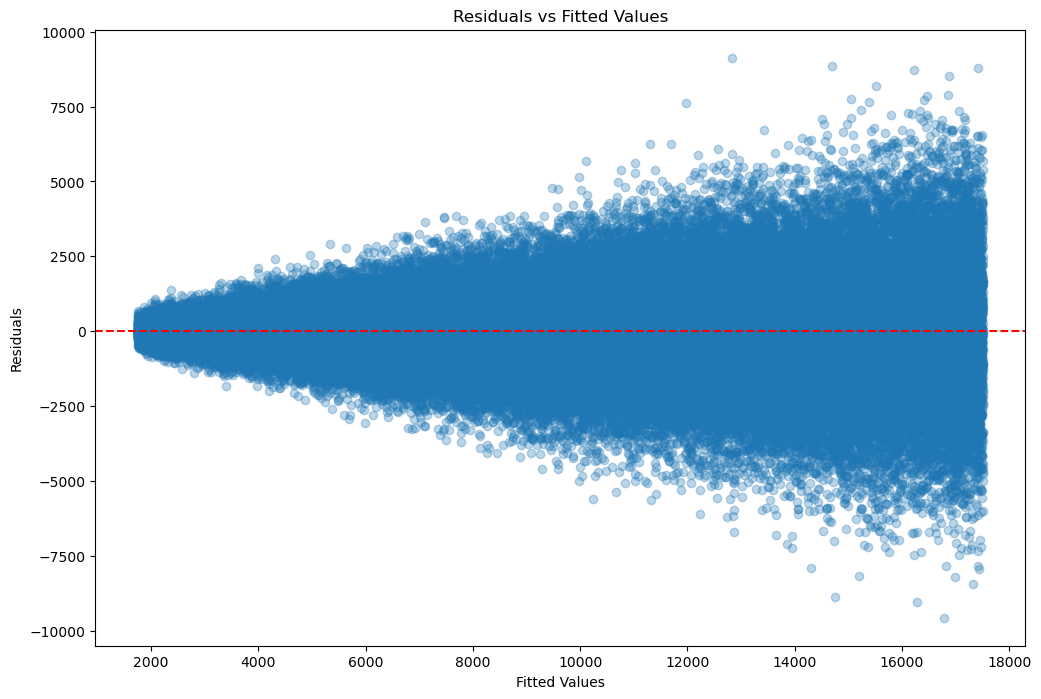

In [17]:
# Residuals vs Fitted Values Plot
plt.figure(figsize=(12, 8))
plt.scatter(model.fittedvalues, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [18]:
# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog)
print(f'Breusch-Pagan test p-value: {bp_test[1]}')
print(f'The residuals {"do not" if bp_test[1] < 0.05 else "do"} have homoscedasticity (reject the null hypothesis).')

Breusch-Pagan test p-value: 0.0
The residuals do not have homoscedasticity (reject the null hypothesis).


In [21]:
# Determine range of Purchase Amount (used later for evaluating model performance)
purchase_amount_range = df['Purchase_Amount'].max() - df['Purchase_Amount'].min()
print(f'The range of the Purchase Amount variable is {purchase_amount_range}')

threshold = (purchase_amount_range * 0.05)
print(f'5% of the Purchase Amount Range is {threshold}')

The range of the Purchase Amount variable is 25086
5% of the Purchase Amount Range is 1254.3000000000002


# Encoding, Train-Test-Split, and StandardScaler

In [ ]:
# Define the dependent/independent variables and apply One-Hot Encoding
X = pd.get_dummies(df.drop(columns=['Purchase_Amount']), drop_first=True)
y = df['Purchase_Amount']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Standardize the features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Grid Search to Determine Best Hyperparameters

In [23]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize the Random Forest model
# rf = RandomForestRegressor(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_

# # Make predictions with the best estimator
# y_pred_best = best_estimator.predict(X_test)

# # Evaluate the model
# mae_best = mean_absolute_error(y_test, y_pred_best)
# mse_best = mean_squared_error(y_test, y_pred_best)
# r2_best = r2_score(y_test, y_pred_best)

# print(f"Best Parameters: {best_params}")
# print(f"Mean Absolute Error (MAE) after tuning: {mae_best}")
# print(f"Mean Squared Error (MSE) after tuning: {mse_best}")
# print(f"R-squared (R2) after tuning: {r2_best}")


# Re-run Model with Best Hyperparameters

In [24]:
# Initialize and train the RandomForestRegressor with the best parameters
best_params = {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model

In [25]:
# Evaluate the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('Random Forest Regressor Evaluation:')
print(f'Mean Absolute Error: {rf_mae}')
print(f'Mean Squared Error: {rf_mse}')
print(f'R-squared: {rf_r2}')

Random Forest Regressor Evaluation:
Mean Absolute Error: 1108.0477874738622
Mean Squared Error: 2349925.1863674354
R-squared: 0.8974922216231431


In [26]:
# Check if the MAE is 5% or less of the range of Purchase Amount
if rf_mae <= threshold:
    print(f'The MAE of the RF model is {rf_mae}, which is 5% or less of the range of Purchase Amount ({threshold}).')
else:
    print(f'The MAE of the RF model is {rf_mae}, which is greater than 5% of the range of Purchase Amount ({threshold}).')

The MAE of the RF model is 1108.0477874738622, which is 5% or less of the range of Purchase Amount (1254.3000000000002).


                          Feature  Importance
1                          Income    0.995085
0                             Age    0.001581
3              Satisfaction_Score    0.000677
4                     Gender_Male    0.000194
9                    Region_South    0.000180
5               Education_College    0.000166
10                    Region_West    0.000164
6            Education_HighSchool    0.000160
2                 Promotion_Usage    0.000156
14        Purchase_Frequency_rare    0.000156
18          Product_Category_Food    0.000149
13  Purchase_Frequency_occasional    0.000149
17   Product_Category_Electronics    0.000146
8                    Region_North    0.000142
19        Product_Category_Health    0.000134
15         Product_Category_Books    0.000132
12          Loyalty_Status_Silver    0.000131
7               Education_Masters    0.000128
16      Product_Category_Clothing    0.000127
20          Product_Category_Home    0.000122
11         Loyalty_Status_Regular 

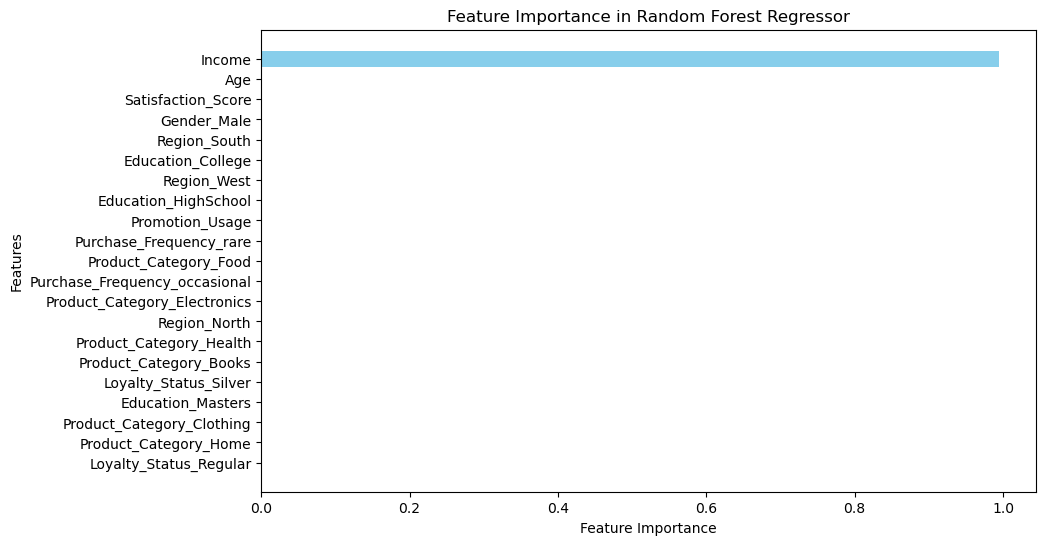

In [27]:
# Determining feature importance
feature_importances = rf_model.feature_importances_
features = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sorting the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor')
plt.gca().invert_yaxis()
plt.show()

# KNN Regressor

In [28]:
# Define the parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

# Initialize GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
knn_model = grid_search.best_estimator_
params = grid_search.best_params_

print(f'Best Parameters: {params}')

# Predict using the best model
knn_predictions = knn_model.predict(X_test_scaled)

Best Parameters: {'n_neighbors': 7}


In [29]:
# Evaluation metrics for the best model
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

print('KNN Regressor Evaluation:')
print(f'Mean Absolute Error: {knn_mae}')
print(f'Mean Squared Error: {knn_mse}')
print(f'R-squared: {knn_r2}')

KNN Regressor Evaluation:
Mean Absolute Error: 1826.345707142857
Mean Squared Error: 5488947.546162245
R-squared: 0.7605626673358212


In [30]:
# Check if the MAE is 5% or less of the range of Purchase Amount
if knn_mae <= threshold:
    print(f'The MAE of the RF model is {knn_mae}, which is 5% or less of the range of Purchase Amount ({threshold}).')
else:
    print(f'The MAE of the RF model is {knn_mae}, which is greater than 5% of the range of Purchase Amount ({threshold}).')

The MAE of the RF model is 1826.345707142857, which is greater than 5% of the range of Purchase Amount (1254.3000000000002).


In [33]:
# Calculate the variance and range of the target variable
variance_purchase_amount = df['Purchase_Amount'].var()
range_purchase_amount = df['Purchase_Amount'].max() - df['Purchase_Amount'].min()

print(f"Variance of purchase_amount: {variance_purchase_amount}")
print(f"Range of purchase_amount: {range_purchase_amount}")


Variance of purchase_amount: 23033659.149623517
Range of purchase_amount: 25086


In [34]:
# Compare MSE to variance
mse_to_variance_ratio = rf_mse / variance_purchase_amount
print(f"MSE to Variance Ratio: {mse_to_variance_ratio}")


MSE to Variance Ratio: 0.10202135800927856


In [35]:
# ANOVA to compare models
anova_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Predicted': rf_predictions,
    'KNN_Predicted': knn_predictions
})

anova_model = ols('Actual ~ RF_Predicted + KNN_Predicted', data=anova_df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print("ANOVA results:")
print(anova_table)

ANOVA results:
                     sum_sq       df             F    PR(>F)
RF_Predicted   5.423196e+10      1.0  23077.827237  0.000000
KNN_Predicted  5.618036e+06      1.0      2.390695  0.122075
Residual       4.699214e+10  19997.0           NaN       NaN
